# Shallow Moments with topography (Simple)

## Imports

In [1]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
import jax
from jax import numpy as jnp
import pytest
from types import SimpleNamespace
from sympy import cos, pi, Piecewise, Matrix

from library.python.fvm.solver_jax import HyperbolicSolver, Settings
from library.python.fvm.ode import RK1
import library.python.fvm.reconstruction as recon
import library.python.fvm.timestepping as timestepping
import library.python.fvm.flux as flux
import library.python.fvm.nonconservative_flux as nc_flux
from library.model.boundary_conditions import BoundaryCondition
from library.model.models.basisfunctions import Basisfunction, Legendre_shifted
from library.model.models.basismatrices import Basismatrices
from library.python.misc.misc import Zstruct

from library.model.models.shallow_moments_topo import ShallowMomentsTopo, ShallowMomentsTopoNumerical
from library.model.models.shallow_moments import ShallowMoments2d

import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
import library.python.misc.io as io
from library.python.mesh.mesh import compute_derivatives
from tests.pdesoft import plots_paper
import library.postprocessing.visualization as visu


import library.python.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing
from library.python.mesh.mesh import convert_mesh_to_jax
import argparse

2025-08-30 13:04:07.259 | WARNING  | library.python.fvm.solver_jax:<module>:28 - No module named 'precice'


## Model

In [2]:
level = 4
offset = 1+level
n_fields = 3 + 2 * level
settings = Settings(
    name="SME",
    output=Zstruct(
        directory=f"outputs/topo_{level}", filename="SME", snapshots=30
    ),
)

2025-08-30 13:04:10.281 | WARNING  | library.python.misc.misc:__init__:146 - No 'clean_directory' attribute found in output Zstruct. Default: False


In [ ]:
inflow_dict = { 
    0: lambda t, x, dx, q, qaux, p, n: q[0],
    1: lambda t, x, dx, q, qaux, p, n: Piecewise((0.1, t < 0.2),(q[1], True)),
    2: lambda t, x, dx, q, qaux, p, n: Piecewise((0.01, t < 0.2),(-q[2], True)),
                }
inflow_dict.update({2+i: lambda t, x, dx, q, qaux, p, n: 0.0 for i in range(1, level+1)})
inflow_dict.update({2+offset+i: lambda t, x, dx, q, qaux, p, n: 0.0 for i in range(level+1)})

bcs = BC.BoundaryConditions(
    [
        BC.Lambda(physical_tag="inflow", prescribe_fields=inflow_dict),
        BC.Wall(physical_tag="wall", momentum_field_indices=[[2+i, 2+offset+i] for i in range(level+1)]),
    ]
)

def custom_ic(x):
    Q = np.zeros(4 + 2 * level, dtype=float)
    Q[0] = x[0] * (0.01)
    Q[1] = np.where(x[0] < 0.35, 0.01, 0.)
    return Q

# def custom_ic_aux(x):
#     Q = custom_ic(x)
#     h = Q[1]
#     # Qaux = np.zeros(1 + 2 + 2 * level, dtype=float)
#     Qaux = np.zeros(1, dtype=float)
#     Qaux[0] = np.where(h > 0, 1/h, 0.0)
#     return Qaux

ic = IC.UserFunction(custom_ic)
# ic_aux = IC.UserFunction(custom_ic_aux)

class MyModel(ShallowMomentsTopoNumerical):
    def source(self):
        out = Matrix([0 for i in range(self.n_variables)])
        out += self.newtonian()
        out += self.slip_mod()
        return self.substitute_precomputed_denominator(out, self.variables[1], self.aux_variables.hinv)
        

model = MyModel(
    level=level,
    boundary_conditions=bcs,
    initial_conditions=ic,
    # aux_initial_conditions=ic_aux,
    parameters=Zstruct(nu=0.000001, lamda=1/1000., c_slipmod=1/30),
    aux_variables = ['hinv'] + [f'dalpha_{i}_dx' for i in range(level+1)] + [f'dbeta_{i}_dy' for i in range(level+1)],
    # aux_variables = ['hinv'],
    
)

main_dir = os.getenv("ZOOMY_DIR")
mesh = petscMesh.Mesh.from_gmsh(
    os.path.join(main_dir, "meshes/channel_junction/mesh_2d_coarse.msh")
    # os.path.join(main_dir, "meshes/channel_junction/mesh_2d_fine.msh")
)

mesh = convert_mesh_to_jax(mesh)
class SMESolver(HyperbolicSolver):
    def update_q(self, Q, Qaux, mesh, model, parameters):
        h = Q[1]
        h = jnp.where(h > 0, h, 0.0)
        eps = 1e-6
        denom = jnp.where(h**2 > eps, h**2, eps)
        factor = (h**2) / denom
        
        Q = Q.at[1].set(h)
        Q = Q.at[2:].multiply(factor)
        return Q
    
    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):
        level = (model.n_variables-2)//2 -1
        offset = 1+level
        ## h with wet/dry fix
        h = Q[1]
        # hinv = 1/h

        ### This does not work for some reason
        # h = jnp.where(h > 0, h, 0.0)
        # eps = 1e-6
        # denom = jnp.sqrt(h**4 + jnp.where(h**4 > eps, h**4, eps))
        # hinv = (jnp.sqrt(2.0) * h) / denom
        # Qaux = Qaux.at[0].set(hinv)
        
        h = jnp.where(h > 0, h, 0.0)
        eps = 1e-6
        denom = jnp.where(h**2 > eps, h**2, eps)
        hinv = (h) / denom
        Qaux = Qaux.at[0].set(hinv)
        
        idxs = jnp.arange(level+1)

        # derivatives of alpha and beta for 3d interpolation
        # dalphaidx for each i
        dalphaidxs = jax.vmap(
            lambda i: compute_derivatives(Q[2+i] * hinv, mesh,
                                        derivatives_multi_index=[[0, 0]])[:, 0]
        )(idxs)

        # dbetaidy for each i
        dbetaidys = jax.vmap(
            lambda i: compute_derivatives(Q[2+offset+i] * hinv, mesh,
                                        derivatives_multi_index=[[0, 1]])[:, 0]
        )(idxs)

        # scatter results into Qaux
        Qaux = Qaux.at[1:1+level+1].set(dalphaidxs)
        Qaux = Qaux.at[1+offset:1+offset+level+1].set(dbetaidys)
        
        return Qaux
# solver = SMESolver(settings=settings, time_end=0.000035, compute_dt=timestepping.constant(dt =0.0000001))

solver = SMESolver(settings=settings, time_end=0.533, compute_dt=timestepping.adaptive(CFL=0.45))

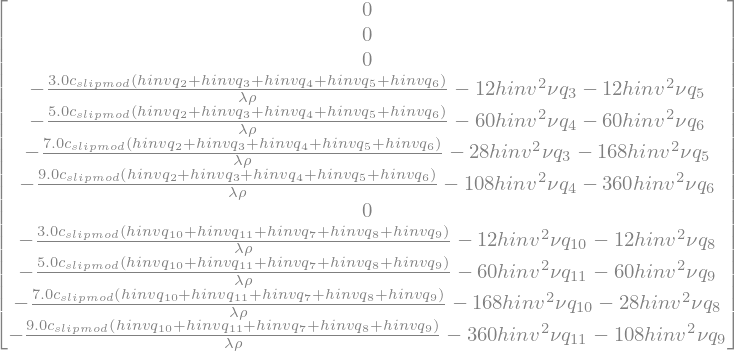

In [4]:
model.source()

## Solve

In [ ]:
Qnew, Qaux = solver.solve(mesh, model)

2025-08-30 12:59:54.836 | INFO     | library.python.fvm.solver_jax:log_callback_hyperbolic:44 - iteration: 10, time: 0.011645, dt: 0.000860, next write at time: 0.044828
2025-08-30 12:59:57.354 | INFO     | library.python.fvm.solver_jax:log_callback_hyperbolic:44 - iteration: 20, time: 0.019959, dt: 0.000810, next write at time: 0.044828
2025-08-30 12:59:59.785 | INFO     | library.python.fvm.solver_jax:log_callback_hyperbolic:44 - iteration: 30, time: 0.027914, dt: 0.000784, next write at time: 0.044828
2025-08-30 13:00:02.192 | INFO     | library.python.fvm.solver_jax:log_callback_hyperbolic:44 - iteration: 40, time: 0.035686, dt: 0.000771, next write at time: 0.044828
2025-08-30 13:00:04.576 | INFO     | library.python.fvm.solver_jax:log_callback_hyperbolic:44 - iteration: 50, time: 0.043362, dt: 0.000764, next write at time: 0.044828
2025-08-30 13:00:07.119 | INFO     | library.python.fvm.solver_jax:log_callback_hyperbolic:44 - iteration: 60, time: 0.050987, dt: 0.000761, next writ

## Visualization

In [6]:
io.generate_vtk(os.path.join(settings.output.directory, f"{settings.output.filename}.h5"))
# postprocessing.vtk_project_2d_to_3d(model, settings, Nz=20, filename='out_3d')

In [ ]:
# visu.pyvista_3d(settings.output.directory, scale=1.0)